In [2]:
import tushare as ts
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pro = ts.pro_api('cbf6f80f4b52edeb90f58193ceb6d578dde99e802322d039d4089f5a')
df = pro.trade_cal(exchange='', start_date='20180901', end_date='20181001', fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
print(df)

   exchange  cal_date  is_open pretrade_date
0       SSE  20180901        0      20180831
1       SSE  20180902        0      20180831
2       SSE  20180908        0      20180907
3       SSE  20180909        0      20180907
4       SSE  20180915        0      20180914
5       SSE  20180916        0      20180914
6       SSE  20180922        0      20180921
7       SSE  20180923        0      20180921
8       SSE  20180924        0      20180921
9       SSE  20180929        0      20180928
10      SSE  20180930        0      20180928
11      SSE  20181001        0      20180928


In [3]:
df1 = ts.get_hist_data('sz')
print(df1)
df1 = df1.reindex(index = df1.index[::-1])
df1.to_csv('./sz_daily.csv')

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
                open      high     close       low       volume  price_change  \
date                                                                            
2020-08-27  13465.89  13548.66  13535.09  13348.45  414995072.0        106.69   
2020-08-26  13680.59  13717.90  13428.40  13376.66  465528416.0       -241.01   
2020-08-25  13692.47  13788.49  13669.41  13620.62  456935744.0          2.72   
2020-08-24  13565.28  13708.12  13666.69  13418.96  410963552.0        188.69   
2020-08-21  13445.96  13547.79  13478.00  13373.72  383524032.0        157.08   
...              ...       ...       ...       ...          ...           ...   
2018-03-05  10882.87  10913.03  10875.68  10813.47  159549536.0         19.43   
2018-03-02  10857.87  10947.39  10856.25  10840.01  184646816.0        -86.88   
2018-03-01  10754.62  10943.13  10943.13  10732.93  190070320.0        114.40   
2018-02-28  10705.81  10875.71  10828.73  10656.36  1866

In [4]:
df1['macd'], df1['dea'], df1['hist'] = ta.MACD(df1['close'])
#print(df1['macd'])

In [5]:
df1['date'] = df1.index
#df1['year_month_day'] = df1['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
df1['df_index'] = range(df1.shape[0])
df1 = df1.set_index('df_index')
df1.head

<bound method NDFrame.head of               open      high     close       low       volume  price_change  \
df_index                                                                      
0         10898.29  10915.36  10807.53  10791.95  195932768.0        -88.03   
1         10705.81  10875.71  10828.73  10656.36  186638944.0         21.20   
2         10754.62  10943.13  10943.13  10732.93  190070320.0        114.40   
3         10857.87  10947.39  10856.25  10840.01  184646816.0        -86.88   
4         10882.87  10913.03  10875.68  10813.47  159549536.0         19.43   
...            ...       ...       ...       ...          ...           ...   
607       13445.96  13547.79  13478.00  13373.72  383524032.0        157.08   
608       13565.28  13708.12  13666.69  13418.96  410963552.0        188.69   
609       13692.47  13788.49  13669.41  13620.62  456935744.0          2.72   
610       13680.59  13717.90  13428.40  13376.66  465528416.0       -241.01   
611       13465.89  13

In [6]:
def is_buytime(dataframe,idx):
    if idx-3>0:
        if dataframe.loc[idx-3,'hist'] > dataframe.loc[idx-2,'hist'] and dataframe.loc[idx-2,'hist'] < dataframe.loc[idx-1,'hist'] < dataframe.loc[idx,'hist'] :
            return True
    return False
print(is_buytime(df1,3))

def is_selltime(dataframe,idx):
    if idx-3>0:
        if dataframe.loc[idx-3,'hist'] < dataframe.loc[idx-2,'hist'] and dataframe.loc[idx-2,'hist'] > dataframe.loc[idx-1,'hist'] and dataframe.loc[idx-1,'hist'] > dataframe.loc[idx,'hist']:
            return True
    return False
print(is_selltime(df1,3))

def daily_action(dataframe,idx,share,cash,br,sr):
    if is_buytime(dataframe,idx):
        if cash > 0 and idx >242:
            share += cash/dataframe.loc[idx,'close']
            cash = 0
            br.append(idx)
    if is_selltime(dataframe,idx):
        if share > 0 and idx >242:
            cash += share*dataframe.loc[idx,'close']
            share = 0
            sr.append(idx)
    value = share*dataframe.loc[idx,'close']+cash
    return share,cash,value

def macd_return(data):
    cash = data.loc[0,'close']
    share = 0
    v_list = []
    br = []
    sr = []
    for idx in range(len(data)):
        share,cash,value = daily_action(data,idx,share,cash,br,sr)
        v_list.append(value)
    data['value'] = v_list
    return br,sr

br,sr = macd_return(df1)

False
False


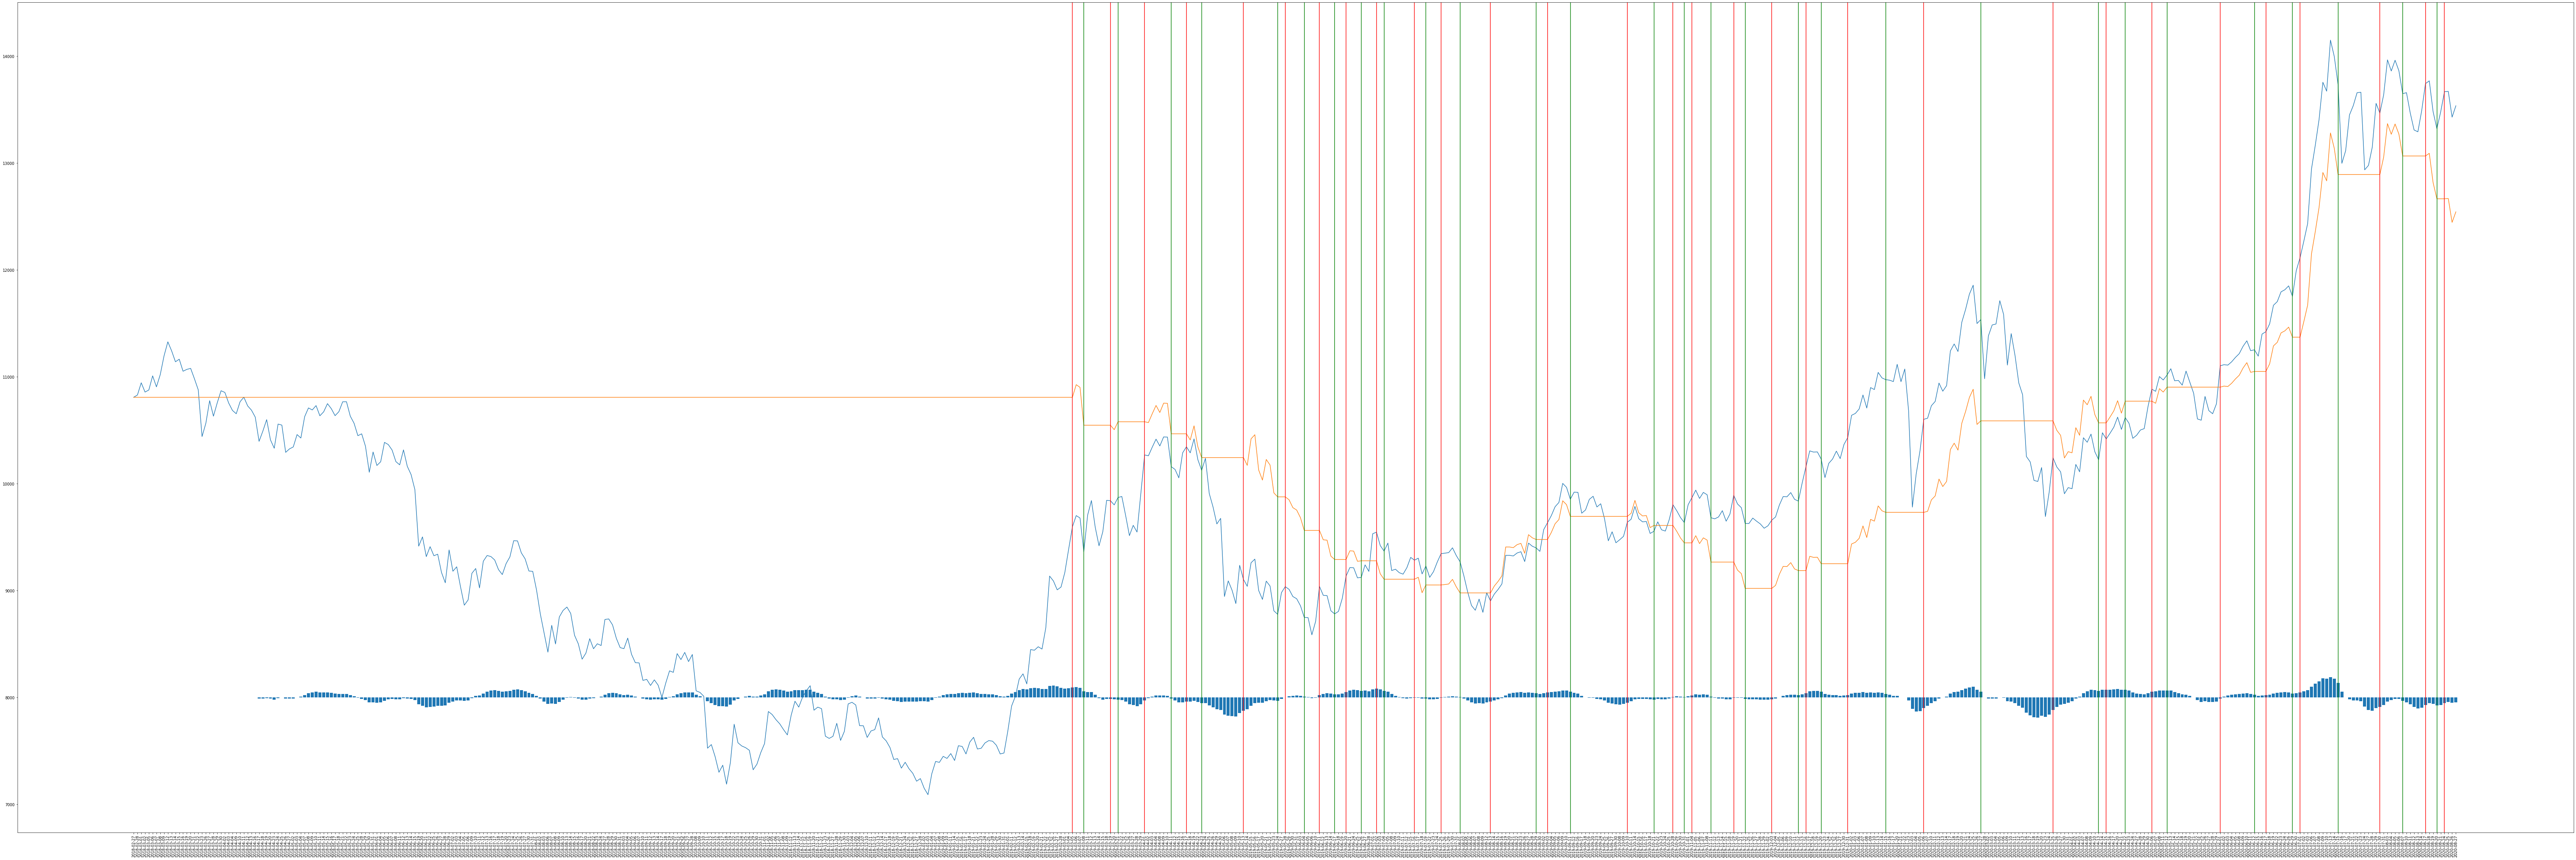

In [7]:
plt.figure(figsize=(120,40))
plt.bar(x= df1.index,height= df1['hist'],bottom=8000)
#plt.plot(df1['hist']+8000)
plt.plot(df1['close'])
plt.plot(df1['value'])
#plt.grid(color="k", linestyle=":")
plt.xticks(df1.index,df1['date'],rotation='vertical')
plt.savefig("test.png", dpi=120)
for xsr in sr:
    plt.axvline(x=xsr,c='green')
for xbr in br:
    plt.axvline(x=xbr,c='red')
plt.savefig('./hist.png')
plt.show()




In [8]:
end = df1.iloc[-1]['value']
start = df1.loc[0,'close']
benefit = end/start-1.0
market_benefit = df1.iloc[-1]['close']/start-1.0
print('The final reward of the strategy is %f %%'%((end/start-1.0)*100))
print('%f %% more than the market index.'%((benefit-market_benefit)*100))

The final reward of the strategy is 16.055969 %
-9.181620 % more than the market index.


In [9]:
df1.to_csv('./game_data.csv')

In [3]:
datapath = './game_data.csv'
df1 = pd.read_csv(datapath)

best_buyprice = min(df1.loc[:,'close'])
best_sellprice = max(df1.loc[:,'close'])
trans = 10000/best_buyprice * best_sellprice
print(trans)



19958.050283238168
